# Training a model to predict head nods based on speaker behaviour

In [1]:
import pickle
import random

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import model_selection
from sklearn import neighbors

import settings
import ml_utils

%matplotlib inline

In [2]:
store = pd.HDFStore('data.hdf')

Dataset stats

In [3]:
len(store)

48

In [4]:
lengths = [store[key].index.max() for key in store]

In [5]:
np.mean(lengths)

Timedelta('0 days 00:02:18.380479')

In [6]:
max(lengths)

Timedelta('0 days 00:04:08.766000')

In [7]:
min(lengths)

Timedelta('0 days 00:00:41.200000')

Interaction 002 as an example

In [8]:
store.interaction002.head(10)

,speaker_behaviour,speaker_eye,listener_nod
time,,,
00:00:00,Start,False,False
00:00:02.800000,Start,True,False
00:00:03.480000,Start,False,False
00:00:03.875000,SpeechNormal,False,False
00:00:04.625000,PunctualPositiveSpeech,False,False
00:00:04.625000,SpeechSilent,False,False
00:00:04.906000,SpeechNormal,False,False
00:00:05.578000,PunctualPositiveSpeech,False,False
00:00:05.578000,SpeechSilent,False,False


Prepare the data

In [9]:
X, y = ml_utils.prepare_training_data(store)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

Training the model

In [10]:
clf = neighbors.KNeighborsClassifier(n_jobs=-1)  # Utilize all cores
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

Evaluating

In [11]:
yhat = clf.predict(X_test)
print(metrics.classification_report(y_test, yhat))

             precision    recall  f1-score   support

      False       0.86      0.96      0.91     13153
       True       0.28      0.08      0.12      2310

avg / total       0.77      0.83      0.79     15463



Measure performance (timing)

In [12]:
sample = X_train[random.randint(0, len(X_train) - 1), :]

In [13]:
%%timeit

clf.predict([sample])

105 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


See how it looks compared to real data

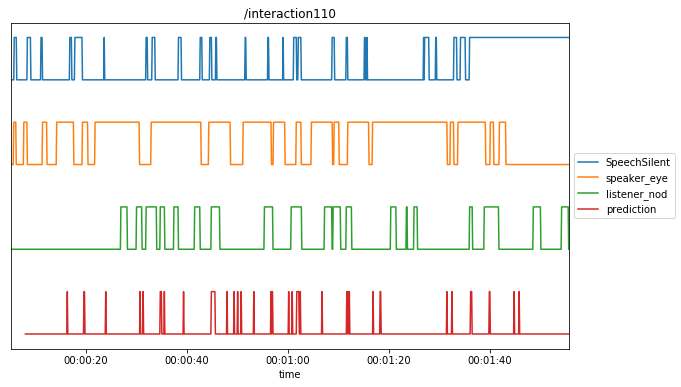

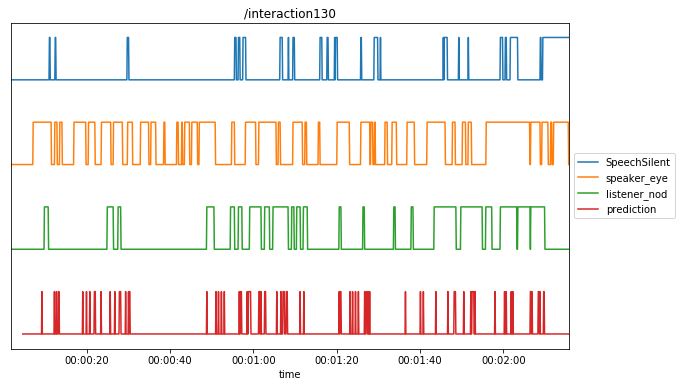

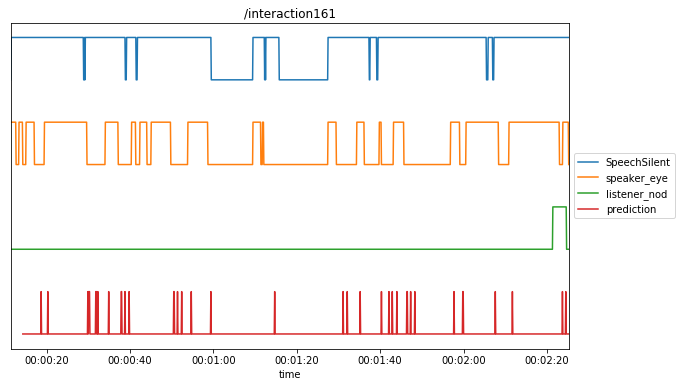

In [14]:
for key in random.sample(store.keys(), 3):
    df = ml_utils.prepare_interaction(store[key])
    samples = ml_utils.to_samples(df, n=settings.WINDOW_SIZE)
    X = samples[:, :-1]
    
    yhat = clf.predict(X)
    
    df['prediction'] = np.nan
    df.loc[-len(yhat):, 'prediction'] = yhat
    
    ml_utils.plot_data(df, title=key)

In [15]:
with open('model.pickle', 'wb') as f:
    pickle.dump(clf, f)